<a href="https://colab.research.google.com/github/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications/blob/ed_branch/Ed_LLM_FineTuning_MedDialog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalized Healthcare QA System (Chatbot) - V3 - MedDialog IC
#### Ed:215279167
---
### Objective:
Develop a healthcare chatbot that answers patient inquiries on medications, symptoms, and  treatments while reducing hallucinations.

### Update and changes:
This updated notebook reflects changes learned from weeks 1 -7 experiments with fine-tuning. Main changes include:
* Revert to using MedDialog dataset to validate model is being fine tuned correctly

### Datasets:
* Med Dialog IC - https://huggingface.co/datasets/lighteval/med_dialog

### Task Breakdown:
1. Train models on medical QA datasets.
2. Fine-tune for patient-friendly responses (simplified, clear language).
3. Ensure context-aware, regulatory-compliant answers:  
o Implement FDA/TGA guideline alignment.
o Develop a retrieval-based validation for generated answers.
4. Deploy as a chatbot interface (React-based UI + API integration).
5. Implement real-time fact-checking:  
o Confidence score visualization (green = high confidence, yellow = medium, red = low
confidence).
o Integration with PubMed and trusted medical sources.

### Models to Use:
• Llama-2 7B

### Evaluation Metrics:
* Rouge, BLEU, Meteor, BertScore, Manual inspection

---
## 1. Import libraries and model to prepare for fine tuning

In [1]:
!pip install datasets requests bitsandbytes accelerate peft trl sentencepiece wandb transformers evaluate rouge_score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00

### IMPORTANT: Restart Colab runtime after PIP install!!!

## 2. Implement base model and imports
First step is to import all necessary libraries and implement base model, to validate it can generate a response from prompt.

In [1]:
from google.colab import userdata
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
    pipeline
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import torch
import wandb
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import evaluate
import numpy as np
from bert_score import BERTScorer

In [2]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
project_name = "ed_medical"
hf_username = "digitalblue"

In [3]:
# log into hugging face and wandb
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = "ed_medical"
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if True else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: digitalblue (digitalblue-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
memory = model.get_memory_footprint() / 1e6
print(f"Memory footprint: {memory:,.1f} MB")

Memory footprint: 3,762.8 MB


In [ ]:
# model architecture
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096

In [ ]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant"},
    {"role": "user", "content": "How can I get rid of the flu?"}
  ]

In [ ]:
# verify base model generates response
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
outputs = model.generate(inputs, max_new_tokens=250)
print(tokenizer.decode(outputs[0]))

<s> [INST] <<SYS>>
You are a helpful personalised medical assistant
<</SYS>>

How can I get rid of the flu? [/INST]  Hello there! I'm glad you asked! 😊 As a helpful personalized medical assistant, I'm here to provide you with some effective ways to help you get rid of the flu.

First and foremost, it's important to understand that the flu is a viral infection, and there's no magic pill or potion that can make it go away overnight. However, there are some things you can do to help manage your symptoms and feel better faster.

1. Stay hydrated: Drink plenty of fluids, such as water, tea, or soup, to help loosen congestion and replace lost fluids. Aim for at least 8-10 glasses of fluid per day.
2. Rest: Give your body the rest it needs to fight off the infection. Try to get at least 8 hours of sleep each night and take naps during the day if needed.
3. Use over-the-counter medications: Over-the-counter medications like acetaminophen (Tylenol) or ibuprofen (Advil, Motrin) can help relieve


## 3. Dataset analysis and preprocessing for Llama
The datasets need to be analysed and prepared for fine-tuning the model. This includes removing invalid data and formatting into the required format with special tokens the Llama 2 model requires. Dataset acquired from HuggingFace
* MedDialog_IC - https://huggingface.co/datasets/lighteval/med_dialog


In [ ]:
# format input from datasets into prompt format required by llama model
def format_llama_prompt(user_message, model_answer):
  prompt = '<s>[INST] ' # special token - commence instruct
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

def format_llama_prompt_with_context(user_message, model_answer, context):
  prompt = '<s>[INST] Given this context: ' # special token - commence instruct
  prompt += context['contexts'][0].strip()
  prompt += ' Question: '
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

In [ ]:
# load med_dialog dataset
med_dialog_ic = load_dataset("lighteval/med_dialog", "icliniq")

0000.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24851 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3108 [00:00<?, ? examples/s]

In [ ]:
med_dialog_ic

DatasetDict({
    train: Dataset({
        features: ['tgt', 'src', 'id'],
        num_rows: 24851
    })
    validation: Dataset({
        features: ['tgt', 'src', 'id'],
        num_rows: 3105
    })
    test: Dataset({
        features: ['tgt', 'src', 'id'],
        num_rows: 3108
    })
})

In [ ]:
med_dialog_ic['train'][100]

{'tgt': 'What is the small yellow bump above my tonsil?',
 'src': 'Patient: Hi doctor, I have a small round yellow bump or circle on the back of the arch, right above my tonsil. It is there for a month. It does not show any changes. I do not have any symptoms or soreness. Doctor: Hi. I have gone through the attachment (attachment removed to protect patient identity). It appears like a small cyst. There can be a fluid collection inside the minor salivary gland. You need not worry about it as it goes down on its own. However, if you have any symptoms, you may need to address it. Since you do not have any signs, we need not worry about it. Occasionally, it could be a tonsillolith which is stone formation inside the naturally occurring crypts of the tonsil. You need not worry unless it is symptomatic. Follow up after six months regarding this yellow spot. For more information consult an ENT otolaryngologist online --> https://www.icliniq.com/ask-a-doctor-online/ENT-Otolaryngologist',
 'id'

In [ ]:
# med_dialog data requires prep to parse patient/doctor chat in src
def prep_med_dialog(src_dialog):
  init_split = src_dialog.split('Patient: ')
  init_split = [item for item in init_split if item] # remove empty item introduced by init split
  if len(init_split) > 2:
    print('Longer dialog: ' + str(init_split))
    return None
  else:
    #print(next_split)
    next_split = init_split[0].split(' Doctor:')
    if len(next_split) > 1:
      return format_llama_prompt(next_split[0], next_split[1])
    else:
      print("Invalid dialog: " + str(src_dialog))
      return None


In [ ]:
# create subset of med_dialag src value
med_dialog_ic_sub = med_dialog_ic['train']['src']

In [ ]:
# create list of formatted prompts
med_dialog_ic_as_prompt = []
for index, dialog in enumerate(med_dialog_ic_sub):
  med_dialog_ic_as_prompt.append(prep_med_dialog(dialog))

In [ ]:
med_dialog_ic_as_prompt[100]

'<s>[INST] Hi doctor, I have a small round yellow bump or circle on the back of the arch, right above my tonsil. It is there for a month. It does not show any changes. I do not have any symptoms or soreness. [/INST] Hi. I have gone through the attachment (attachment removed to protect patient identity). It appears like a small cyst. There can be a fluid collection inside the minor salivary gland. You need not worry about it as it goes down on its own. However, if you have any symptoms, you may need to address it. Since you do not have any signs, we need not worry about it. Occasionally, it could be a tonsillolith which is stone formation inside the naturally occurring crypts of the tonsil. You need not worry unless it is symptomatic. Follow up after six months regarding this yellow spot. For more information consult an ENT otolaryngologist online --> https://www.icliniq.com/ask-a-doctor-online/ENT-Otolaryngologist </s>'

In [ ]:
print(len(med_dialog_ic_as_prompt))
print(med_dialog_ic_as_prompt[0])

24851
<s>[INST] Hello doctor, My friend aged 30 had two drops of phenol mistaking for milk. He vomited and had lot of salt water. Please advice for any side effect. [/INST] Hi. I want to assure you not to worry as everything is going to be fine if proper care and treatment is opted in for. I have thoroughly gone through your case and can well understand your genuine health concerns. 1. No, there is not much problem right now as he vomited and also had a lot of water. It is fine because it was only two drops. 2. We usually do not go for emesis (vomiting) for phenol poisoning cases. Because, it is a volatile compound and causes vapors entering the lungs through the airways. 3. As it was only two drops, I do not think it may cause much trouble. If he feels short of breath contact me back, otherwise fine. 1. He should avoid re-exposure. 2. Rule out if there is some sort of suicidal ideation due to depression or anxiety and take him to a psychiatrist for physical evaluation. For further fol

In [ ]:
# collect all formatted data into one dataset
prompt_dataset = med_dialog_ic_as_prompt
print(len(prompt_dataset))

24851


In [ ]:
# convert to huggingface dataset, create splits and push to hub
prompt_hf_dataset = Dataset.from_dict({"text": prompt_dataset})

In [ ]:
ds_train = prompt_hf_dataset.train_test_split(test_size=0.2, seed=42)

In [ ]:
ds_train

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 19880
    })
    test: Dataset({
        features: ['text'],
        num_rows: 4971
    })
})

In [ ]:
ds_test = ds_train['test'].train_test_split(test_size=0.5, seed=42)
ds_test

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2485
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2486
    })
})

In [ ]:
ds_splits = DatasetDict({
    'train': ds_train['train'],
    'validation': ds_test['train'],
    'test': ds_test['test']
})

In [ ]:
ds_splits

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 19880
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2485
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2486
    })
})

In [ ]:
# push to hugging face
ds_splits.push_to_hub(f"{hf_username}/{project_name}-med-dialog-ic", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/ed_medical-med-dialog-ic/commit/f97aa80aa05fc6888b489d55ca90b4f68c8ee458', commit_message='Upload dataset', commit_description='', oid='f97aa80aa05fc6888b489d55ca90b4f68c8ee458', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/ed_medical-med-dialog-ic', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/ed_medical-med-dialog-ic'), pr_revision=None, pr_num=None)

## 4. Model Training Pipeline
The model training pipeline is setup for fine-tuning. During this process additional data processing was required to filter out data with execessive token length that would exhaust GPU resources.

Initially four variants(A,B,C,D) of the model were fine-tuned on combination dataset, however focus is now on a single model trained on Med Dialog IC dataset. It maintains integration with HuggingFace and Weight and Bias platform so models and runs are saved for later retrieval.

The models were fine-tuned on the **train** set, and evaluated with **validation** set.

In [ ]:
qa_dataset = load_dataset("digitalblue/ed_medical-med-dialog-ic")
qa_dataset

README.md:   0%|          | 0.00/527 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.05M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2485 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2486 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 19880
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2485
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2486
    })
})

In [ ]:
# getting token lengths from training dataset
train_length = []
train_token_length = []
for item in qa_dataset['train']:
  if item['text']:
    train_length.append(len(item['text']))
    tokens = tokenizer.encode(item['text'])
    train_token_length.append(len(tokens))
  else:
    print(item)

In [ ]:
len(train_token_length)

19880

In [ ]:
# print the min, max and average character lengths and token count lengths for training data
print(min(train_length), max(train_length), sum(train_length)/len(train_length))
print(min(train_token_length), max(train_token_length), sum(train_token_length)/len(train_token_length))

84 8371 1173.2094064386317
28 2098 311.1887323943662


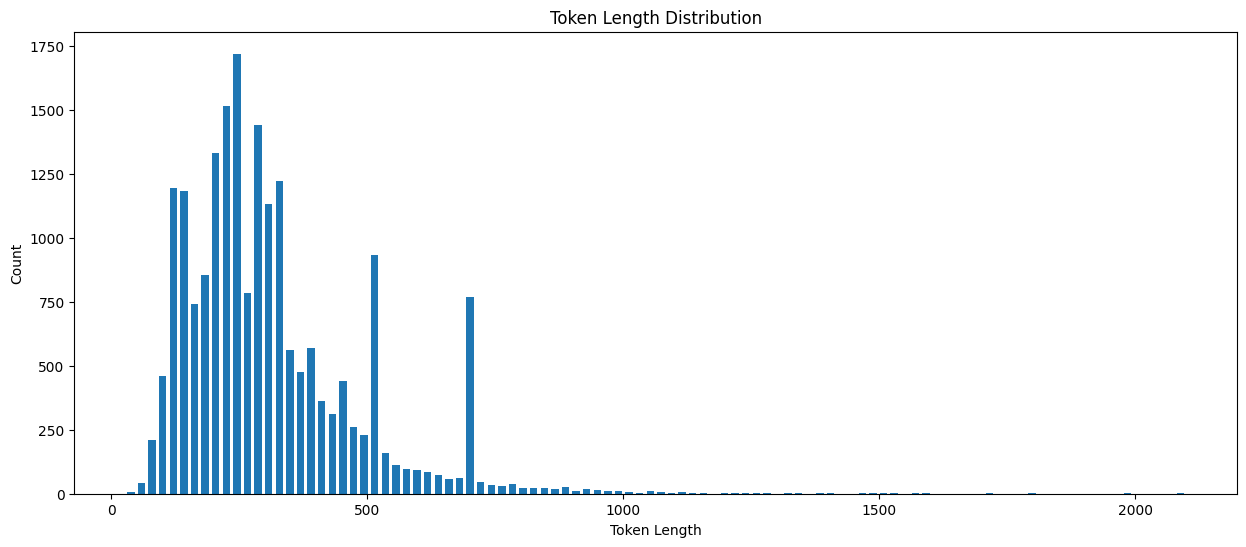

In [ ]:
# plot the token lengths
plt.figure(figsize=(15, 6))
plt.hist(train_token_length, rwidth=0.7, bins=100)
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.show()

In [ ]:
# avg is now approx 311, but will keep 350 tokens, therefore will create new datasets
# to filter out any rows above this token count
MAX_TOKENS = 350
DATASET_SIZE = 1000
def get_filtered_dataset(dataset, max_tokens, size):
  count = 0
  train_size = round(size * 0.9) # 90% for train
  valid_size = round(size * 0.1) # 10% for eval
  print(f"Train size: {train_size}, Eval size: {valid_size}")

  filtered_train_dataset = []
  for item in dataset['train']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_train_dataset.append(item)
        count += 1
      if count >= train_size:
        break

  count = 0
  filtered_eval_dataset = []
  for item in dataset['validation']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_eval_dataset.append(item)

        count += 1
      if count >= valid_size:
        break

  return filtered_train_dataset, filtered_eval_dataset

In [ ]:
qa_train, qa_val = get_filtered_dataset(qa_dataset, MAX_TOKENS, DATASET_SIZE)
qa_train = Dataset.from_list(qa_train)
qa_val = Dataset.from_list(qa_val)
print(qa_train)
print(qa_val)

Train size: 900, Eval size: 100
Dataset({
    features: ['text'],
    num_rows: 900
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [ ]:
qa_val[10]

{'text': '<s>[INST] Hello doctor, My friend aged 30 had two drops of phenol mistaking for milk. He vomited and had lot of salt water. Please advice for any side effect. [/INST] Hi. I want to assure you not to worry as everything is going to be fine if proper care and treatment is opted in for. I have thoroughly gone through your case and can well understand your genuine health concerns. 1. No, there is not much problem right now as he vomited and also had a lot of water. It is fine because it was only two drops. 2. We usually do not go for emesis (vomiting) for phenol poisoning cases. Because, it is a volatile compound and causes vapors entering the lungs through the airways. 3. As it was only two drops, I do not think it may cause much trouble. If he feels short of breath contact me back, otherwise fine. 1. He should avoid re-exposure. 2. Rule out if there is some sort of suicidal ideation due to depression or anxiety and take him to a psychiatrist for physical evaluation. For further

In [ ]:
# set constants
MAX_SEQUENCE_LENGTH = 350 # calculated from avg token lenght in dataset

# Run name for saving the model in the hub
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{project_name}-{RUN_NAME}"
HUB_MODEL_NAME = f"{hf_username}/{PROJECT_RUN_NAME}"

# qlora hyper params
LORA_R = 16 # Reduce LoRA rank (lower = less memory) , initial = 32
LORA_ALPHA = 32 # Lower alpha , initial = 64
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]
LORA_DROPOUT = 0.05
QUANT_4_BIT = True

# training hyper params
EPOCHS = 3
BATCH_SIZE = 4  # Reduce batch size , initial = 4
GRADIENT_ACCUMULATION_STEPS = 8  # Simulate batch size 8, initial = 1
LEARNING_RATE = 2e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"
STEPS = 20
SAVE_STEPS = 2000
LOG_TO_WANDB = True

In [ ]:
response_template = " [/INST] "
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [ ]:
lora_params = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
training_params = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    #eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if True else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
    #neftune_noise_alpha=5 # using NEFTune as describe in SFT Trainer docs for increased conversational quality
)

In [ ]:
!nvidia-smi

Mon May 12 02:32:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             25W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# clear gpu memory
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
# Prepare the model for k-bit training (important for 4-bit)
model = prepare_model_for_kbit_training(model)

In [ ]:
model = get_peft_model(model, lora_params)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=qa_train,
    eval_dataset=qa_val,
    peft_config=lora_params,
    args=training_params
)


Converting train dataset to ChatML:   0%|          | 0/900 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
#torch.cuda.empty_cache()
trainer.train()
trainer.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Model saved to HuggingFace as: {PROJECT_RUN_NAME}")
model.save_pretrained(PROJECT_RUN_NAME)


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,2.291700
40,1.684000
60,1.459900
80,1.404900


wandb: Adding directory to artifact (./ed_medical-2025-05-12_02.31.47/checkpoint-84)... Done. 0.8s
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


README.md:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Model saved to HuggingFace as: ed_medical-2025-05-12_02.31.47


In [ ]:
results = trainer.evaluate()
print(results)


{'eval_loss': 1.3957768678665161, 'eval_runtime': 184.2312, 'eval_samples_per_second': 0.543, 'eval_steps_per_second': 0.543}


In [ ]:
wandb.finish()

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅███
train/global_step,▁▃▅███
train/grad_norm,█▂▅▁
train/learning_rate,█▆▃▁
train/loss,█▃▁▁
train/mean_token_accuracy,▁▅▇███
train/num_tokens,▁▃▅▇██


In [ ]:
!zip -r ed_medical-2025-05-12_02.31.47.zip ed_medical-2025-05-12_02.31.47

  adding: ed_medical-2025-05-12_02.31.47/ (stored 0%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/ (stored 0%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/rng_state.pth (deflated 25%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/adapter_model.safetensors (deflated 7%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/training_args.bin (deflated 51%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/optimizer.pt (deflated 8%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/trainer_state.json (deflated 63%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/special_tokens_map.json (deflated 74%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/tokenizer.model (deflated 55%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/scheduler.pt (deflated 57%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/tokenizer.json (deflated 85%)
  adding: ed_medical-2025-05-12_02.31.47/checkpoint-84/tokenizer_config.json (deflated 66%)


In [ ]:
!ls -la

total 243168
drwxr-xr-x 1 root root      4096 May 12 06:04 .
drwxr-xr-x 1 root root      4096 May 12 02:24 ..
drwxr-xr-x 4 root root      4096 May  8 13:38 .config
drwxr-xr-x 3 root root      4096 May 12 06:01 ed_medical-2025-05-12_02.31.47
-rw-r--r-- 1 root root 248971266 May 12 06:04 ed_medical-2025-05-12_02.31.47.zip
drwxr-xr-x 1 root root      4096 May  8 13:38 sample_data
drwxr-xr-x 3 root root      4096 May 12 02:36 wandb


In [ ]:
!cp ed_medical-2025-05-12_02.31.47.zip /content/drive/MyDrive/

cp: cannot create regular file '/content/drive/MyDrive/': No such file or directory


In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
from google.colab import runtime
runtime.unassign()

## 5. Evaluate the models - generate evaluation data
At this step the fine-tuned model created in the previous step can be re-loaded without need to re-run step 4. Generated responses will be collected, in addition to the base model to use as a benchmark.

The prompts to generate the responses are 50 samples from the **test** set which was not used for fine-tuning.

The generated response for each model are then saved to HuggingFace hub for later analysis.

In [5]:
# define models saved to huggingface hub from previous step
MODEL_A = "digitalblue/ed_medical-2025-04-03_09.11.29" # trained on 200 rows
MODEL_B = "digitalblue/ed_medical-2025-04-05_10.59.54" # trained on 800 rows
MODEL_C = "digitalblue/ed_medical-2025-04-05_11.36.32" # trained on 1600 rows
MODEL_D = "digitalblue/ed_medical-2025-04-06_10.40.29" # trained on 1600 rows with NEFTune
MODEL_E = "digitalblue/ed_medical-2025-04-15_12.43.48" # trained on 8000 rows of pubmedqa only w/ NEFTune
MODEL_F = "digitalblue/ed_medical-2025-05-05_23.51.25" # trained on 9000 row, lower learing rate, 3 epochs
MODEL_G = "digitalblue/ed_medical-2025-05-08_01.23.37" # trained on 9000 rows, NEFTune false
MODEL_H = "digitalblue/ed_medical-2025-05-11_04.05.52" # trained on 900 row, with context, 3 epochs
MODEL_I = "digitalblue/ed_medical-2025-05-12_02.31.47" # trained on 900 rows of MedDialog

In [6]:
# NOTE: Only using model I for MedDialog

In [7]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [8]:
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto")

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [9]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [10]:
qa_test = load_dataset("digitalblue/ed_medical-med-dialog-ic", split="test[:50]") # first 50 from test set
#qa_test = load_dataset("digitalblue/ed_medical-pubmedqa-artifical", split="test[:50]") # load only pubmedqa YES rows, test set

README.md:   0%|          | 0.00/527 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/9.05M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2485 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2486 [00:00<?, ? examples/s]

In [11]:
# split into question and answer list
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [14]:
qa_list[40][0] # question

'Hello doctor, My friend aged 30 had two drops of phenol mistaking for milk. He vomited and had lot of salt water. Please advice for any side effect.'

In [15]:
prompt1 = "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."
#prompt2 = "You are a helpful personalised medical assistant. Provide a friendly personal response to the patients medical question within a paragraph, provide the necessary details. Follow up it they need more information"

def get_model_responses(model_x, qa_list):
  model_responses = []
  for item in qa_list:
    question = item[0]
    # print(item)
    # print(question)
    # print("-----")
    messages = [
      {"role": "system", "content": prompt1},
      {"role": "user", "content": question}
    ]
    inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    outputs = model_x.generate(inputs, max_new_tokens=250, temperature=0.1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    answer = response.split('[/INST] ')[1]  # get text after /INST token
    answer = answer.replace('</s>', '') # remove trailing special token if present
    model_responses.append(answer)
  return model_responses

In [16]:
model_base_responses_med_dialog = get_model_responses(model_base, qa_list)
prompt_base_med_dialog_dataset = Dataset.from_dict({"text": model_base_responses_med_dialog})
prompt_base_med_dialog_dataset.push_to_hub(f"{hf_username}/model_base_responses_med_dialog", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_base_responses_med_dialog/commit/287eeed90021aec9c859caa63f68ea707322ce26', commit_message='Upload dataset', commit_description='', oid='287eeed90021aec9c859caa63f68ea707322ce26', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_base_responses_med_dialog', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_base_responses_med_dialog'), pr_revision=None, pr_num=None)

In [19]:
model_i = PeftModel.from_pretrained(model_base, MODEL_I)

adapter_config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

In [25]:
print(model_base.lm_head.weight[1000, :20])
print(model_i.lm_head.weight[1000, :20])

tensor([ 0.0009, -0.0043,  0.0259, -0.0030, -0.0270,  0.0030,  0.0097,  0.0096,
        -0.0035, -0.0179,  0.0415,  0.0315, -0.0107,  0.0056,  0.0121,  0.0184,
         0.0088, -0.0099,  0.0195, -0.0232], device='cuda:0',
       dtype=torch.float16)
tensor([ 0.0009, -0.0043,  0.0259, -0.0030, -0.0270,  0.0030,  0.0097,  0.0096,
        -0.0035, -0.0179,  0.0415,  0.0315, -0.0107,  0.0056,  0.0121,  0.0184,
         0.0088, -0.0099,  0.0195, -0.0232], device='cuda:0',
       dtype=torch.float16)


In [29]:
model_i_responses = get_model_responses(model_i, qa_list)
prompt_i_dataset = Dataset.from_dict({"text": model_i_responses})
prompt_i_dataset.push_to_hub(f"{hf_username}/model_i_responses", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/digitalblue/model_i_responses/commit/63b2c60c25952eea26fd92d85b45dd592c5be46e', commit_message='Upload dataset', commit_description='', oid='63b2c60c25952eea26fd92d85b45dd592c5be46e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/digitalblue/model_i_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='digitalblue/model_i_responses'), pr_revision=None, pr_num=None)

In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
from google.colab import runtime
runtime.unassign()

## 6. Evaluate fine tuned models - get metrics from generated responses
In this final step, the generated response can be reloaded from HuggingFace to evaluate and calculate metrics against the expected responses in **test** dataset.

In [30]:
qa_test = load_dataset("digitalblue/ed_medical-med-dialog-ic", split="test[:50]") # load only pubmedqa YES rows, test set

In [31]:
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [32]:
qa_list[40][1] # index 1 is dataset real response

'Hi. I want to assure you not to worry as everything is going to be fine if proper care and treatment is opted in for. I have thoroughly gone through your case and can well understand your genuine health concerns. 1. No, there is not much problem right now as he vomited and also had a lot of water. It is fine because it was only two drops. 2. We usually do not go for emesis (vomiting) for phenol poisoning cases. Because, it is a volatile compound and causes vapors entering the lungs through the airways. 3. As it was only two drops, I do not think it may cause much trouble. If he feels short of breath contact me back, otherwise fine. 1. He should avoid re-exposure. 2. Rule out if there is some sort of suicidal ideation due to depression or anxiety and take him to a psychiatrist for physical evaluation. For further follow up consult a general practitioner online.---> https://www.icliniq.com/ask-a-doctor-online/general-practitioner'

In [33]:
qa_references = [item[1] for item in qa_list] # get list of reference responses

In [34]:
# load saved response data to evaluate
model_base_med_dialog_dataset = load_dataset("digitalblue/model_base_responses_med_dialog")
model_i_dataset = load_dataset("digitalblue/model_i_responses")

README.md:   0%|          | 0.00/266 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/265 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [35]:
# convert to list
base_med_dialog_response_list = model_base_med_dialog_dataset['train']['text'][:50]
i_response_list = model_i_dataset['train']['text']

In [36]:
def calc_rouge_metric(references, predictions):
  rouge = evaluate.load('rouge')
  results = rouge.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_bleu_metric(references, predictions):
  bleu = evaluate.load('bleu')
  results = bleu.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_meteor_metric(references, predictions):
  meteor = evaluate.load('meteor')
  results = meteor.compute(
    predictions=predictions,
    references=[[ref] for ref in references]
  )
  return results

def calc_bert_score(references, predictions):
  bert_scorer = BERTScorer(model_type='bert-base-uncased')
  P = []
  R = []
  F1 = []

  for i in range(len(predictions)):
    p_i, r_i, f1_i = bert_scorer.score([predictions[i]], [references[i]])
    P.append(p_i)
    R.append(r_i)
    F1.append(f1_i)
  results = {
    'P': np.mean(P),
    'R': np.mean(R),
    'F1': np.mean(F1)
  }
  return results

In [37]:
rouge_base_med_dialog = calc_rouge_metric(qa_references, base_med_dialog_response_list)
rouge_i = calc_rouge_metric(qa_references, i_response_list)

In [38]:
print(rouge_base_med_dialog)
print(rouge_i)

{'rouge1': np.float64(0.20294088749028538), 'rouge2': np.float64(0.02361764621026269), 'rougeL': np.float64(0.10506680040438876), 'rougeLsum': np.float64(0.13427478907815524)}
{'rouge1': np.float64(0.38513670670116207), 'rouge2': np.float64(0.288323220950919), 'rougeL': np.float64(0.3663538906069719), 'rougeLsum': np.float64(0.3665033245181065)}


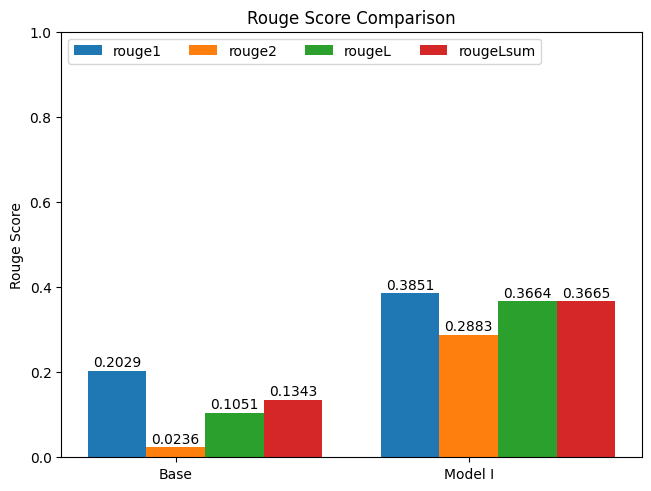

In [39]:
# plot rouge scores
rouge_dict = {
    'rouge1': (rouge_base_med_dialog['rouge1'], rouge_i['rouge1']),
    'rouge2': (rouge_base_med_dialog['rouge2'], rouge_i['rouge2']),
    'rougeL': (rouge_base_med_dialog['rougeL'], rouge_i['rougeL']),
    'rougeLsum': (rouge_base_med_dialog['rougeLsum'], rouge_i['rougeLsum'])
}
model_labels = ('Base', 'Model I')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in rouge_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Rouge Score')
ax.set_title('Rouge Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [40]:
bleu_base_med_dialog = calc_bleu_metric(qa_references, base_med_dialog_response_list)
bleu_i = calc_bleu_metric(qa_references, i_response_list)

In [41]:
print(bleu_base_med_dialog)
print(bleu_i)

{'bleu': 0.016551047075983986, 'precisions': [0.21872322193658955, 0.0323066982554383, 0.005738414898224339, 0.001850642281733072], 'brevity_penalty': 1.0, 'length_ratio': 1.3653114945890612, 'translation_length': 9336, 'reference_length': 6838}
{'bleu': 0.04662877916583039, 'precisions': [0.588534442903375, 0.4103170847136772, 0.34997576345128456, 0.31793343268753105], 'brevity_penalty': 0.11516953982966711, 'length_ratio': 0.3163205615677099, 'translation_length': 2163, 'reference_length': 6838}


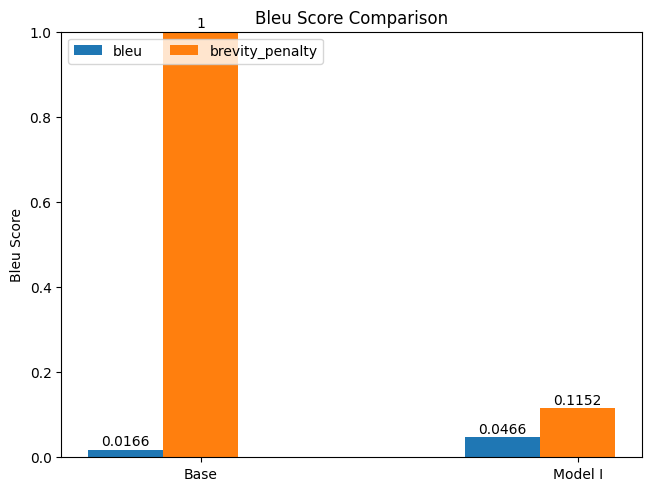

In [42]:
# plot bleu scores
bleu_dict = {
    'bleu': (bleu_base_med_dialog['bleu'], bleu_i['bleu']),
    'brevity_penalty': (bleu_base_med_dialog['brevity_penalty'], bleu_i['brevity_penalty'])
}

model_labels = ('Base', 'Model I')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bleu_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bleu Score')
ax.set_title('Bleu Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [43]:
meteor_base_med_dialog = calc_meteor_metric(qa_references, base_med_dialog_response_list)
meteor_i = calc_meteor_metric(qa_references, i_response_list)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:
print(meteor_base_med_dialog)
print(meteor_i)

{'meteor': np.float64(0.17605032981349583)}
{'meteor': np.float64(0.3343370780511959)}


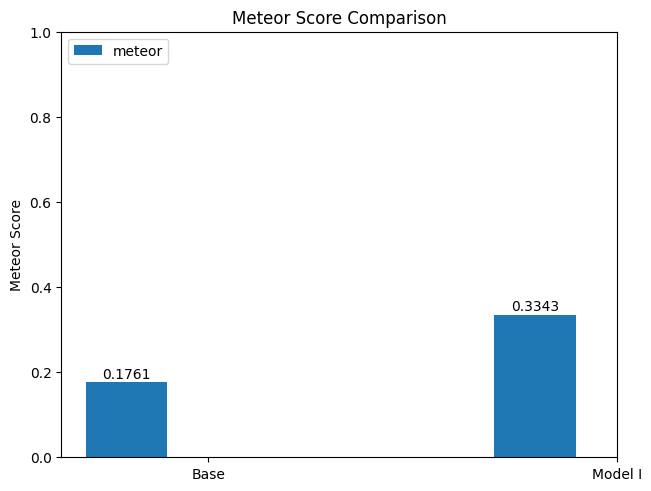

In [46]:
# plot meteor scores
meteor_dict = {
    'meteor': (meteor_base_med_dialog['meteor'], meteor_i['meteor'])
}
model_labels = ('Base', 'Model I')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in meteor_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Meteor Score')
ax.set_title('Meteor Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [47]:
bert_score_base_med_dialog = calc_bert_score(qa_references, base_med_dialog_response_list)
bert_score_i = calc_bert_score(qa_references, i_response_list)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [48]:
print(bert_score_base_med_dialog)
print(bert_score_i)

{'P': np.float32(0.47369266), 'R': np.float32(0.474428), 'F1': np.float32(0.47294253)}
{'P': np.float32(0.72214913), 'R': np.float32(0.6048881), 'F1': np.float32(0.6463166)}


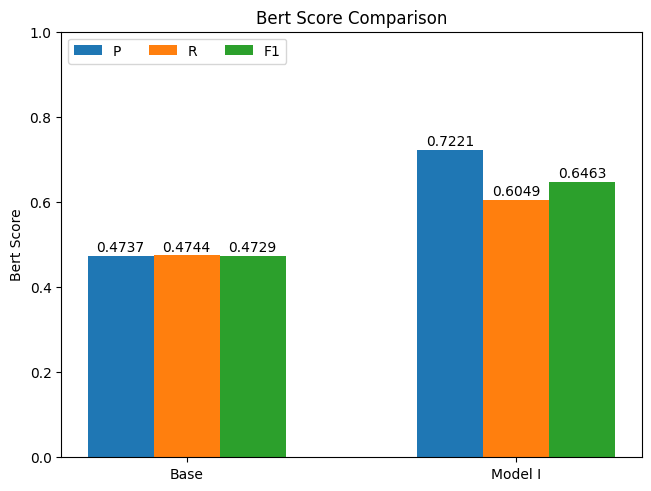

In [49]:
# plot bert scores
bert_score_dict = {
    'P': (bert_score_base_med_dialog['P'], bert_score_i['P']),
    'R': (bert_score_base_med_dialog['R'], bert_score_i['R']),
    'F1': (bert_score_base_med_dialog['F1'], bert_score_i['F1'])
}
model_labels = ('Base', 'Model I')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bert_score_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bert Score')
ax.set_title('Bert Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [50]:
# human evaluation
def print_response(QA_NUM):
  for i in range(QA_NUM):
    print('-----------------------------------------')
    print('\nTest question: ' + qa_list[i][0])
    print('\nTest answer: ' + qa_list[i][1])
    print('\nBase: ' + base_med_dialog_response_list[i])
    print('\nModel I: ' + i_response_list[i])

print_response(5)

-----------------------------------------

Test question: Hi doctor, I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached.

Test answer: Hello. I have gone through your information and test reports (attachment removed to protect patient identity). So, in view of that, there are a couple of things that I can opine upon: Hope that helps. For more information consult a general surgeon online --> https://icliniq.com./ask-a-doctor-online/general-surgeon

Base:  Thank you for reaching out to me with your concerns. I understand that you are experiencing some unusual symptoms, including passing blood with bowel movements, constipation, and diarrhea. While it is understandable th

## 7. Evaluation Summary
Changing the dataset to MedDialog IC shows that the fine-tuned Model_I performs better than the base model.

On human inspection the Llama 2 base model provides a more conversational response, however the fine-tuned model response aligns better with the dataset, indicating that it has learned from the training.

This suggests that the base Llama model was not trained on MedDialog dataset, whereas PubMedQA dataset may have been used to train Llama 2.

Next steps:
* Continue to experiment with further hyperparameter tuning
* Increase volume of training data
* Adjust system prompt, and model parameters on inference
* Improve the pre-processing of the dataset, to provide a more useful answer via the Chatbot



---

